# Deep face recognition (available online [here](https://colab.research.google.com/drive/1qPZuaBl5p9TVYdo613eiQyE72NSwhel5?usp=sharing))

Free GPU memory if necessary

In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache() 

  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=ded1e54cde664657311076b64cafe1f1676cb7ca93add5c4ad4a966532868747
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  1% |  2% |


# Packages import

In [ ]:
# Colab only
# download and install Pytorch
!pip install torch torchvision

In [ ]:
# import the packages
import math, cv2, os, os.path, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
from pathlib import Path
from typing import Any, Callable, cast, Dict, List, Optional, Tuple

# import PyTorch (Deep Learning lib)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

# Drive mounting

In [ ]:
# mount the google drive
from google.colab import drive
drive.mount('/content/drive')
# path to the image on the drive, change it to your will
attribute_path = "/content/drive/MyDrive/Colab Notebooks/Projet_TI/Database/"
dataset_path = "/content/drive/MyDrive/Colab Notebooks/Projet_TI/Database/lfw-deepfunneled-ds/"

Mounted at /content/drive


# Load dataset

In [ ]:
lfw_allnames = pd.read_csv(attribute_path + "lfw_allnames_ds.csv")
print(lfw_allnames.head())

nbLabels = lfw_allnames.shape[0]
print(f"There are {nbLabels} distinct personnalities in this dataset")

lfw_reduced = lfw_allnames.loc[lfw_allnames.images > 20]
lfw_reduced.shape

               name  images
0      Abdullah_Gul      19
1  Alejandro_Toledo      39
2      Alvaro_Uribe      35
3   Amelie_Mauresmo      21
4      Andre_Agassi      36
There are 86 distinct personnalities in this dataset


(53, 2)

Creation of the dataset from data: 
- we split the data in train(80%), test, and validation test
- we make some data augmentation (random flip)
- we use the convenient dataloader format

In [ ]:
def isValidFile(path):
    # The use may be toggled on or off in load_data
    # This may be used to adjust numbers but is unefficient. The dataset has  
    # been sorted, which is also innefficient but only has to be done once.
    dir = Path(path).parent
    count = len([name for name in os.listdir(dir) if os.path.isfile(os.path.join(dir, name))])
    if count > 20: return True
    return False

data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
LFW_dataset = datasets.ImageFolder(
    root=dataset_path,
    transform=data_transform,
    #is_valid_file = isValidFile 
)

def load_data(test_split, batch_size):
    """Loads the data"""
    # Create indices for the split
    dataset_size = len(LFW_dataset)
    val_size = int(test_split*dataset_size*5/6)
    test_size = int(test_split*dataset_size/6)
    train_size = dataset_size-test_size-val_size
    # Split data
    train_dataset, val_dataset, test_dataset = random_split(
        LFW_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )
    # Create datasets loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    return train_loader, val_loader, test_loader 



batchSize = 16
testSplit = 0.2
trainloader, valloader, testloader = load_data(testSplit, batchSize)

# CNN creation

The CNN has been taken from the reference article. We only removed the 7th layer, which reduced the time per epoch without significant changes in performance.

In [ ]:
# create the neural network with Pytorch
class MonReseau(nn.Module):
  """Convolutional neural network."""

  def __init__(self, in_channels, out_channels):
    """Init fields."""
    super(MonReseau, self).__init__()

    self.in_channels = in_channels

    self.conv11 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
    self.bn11 = nn.BatchNorm2d(64)
    self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.bn12 = nn.BatchNorm2d(64)

    self.conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn21 = nn.BatchNorm2d(128)
    self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.bn22 = nn.BatchNorm2d(128)

    self.conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.bn31 = nn.BatchNorm2d(256)
    self.conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.bn32 = nn.BatchNorm2d(256)
    self.conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.bn33 = nn.BatchNorm2d(256)

    self.conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.bn41 = nn.BatchNorm2d(512)
    self.conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn42 = nn.BatchNorm2d(512)
    self.conv43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn43 = nn.BatchNorm2d(512)

    self.conv51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn51 = nn.BatchNorm2d(512)
    self.conv52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn52 = nn.BatchNorm2d(512)
    self.conv53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn53 = nn.BatchNorm2d(512)

    self.conv6 = nn.Conv2d(512, 4096, kernel_size=7, padding=0)
    self.bn6 = nn.BatchNorm2d(4096)

    # self.conv7 = nn.Conv2d(4096, 4096, kernel_size=1, padding=0)
    # self.bn7 = nn.BatchNorm2d(4096)

    self.conv8 = nn.Conv2d(4096, nbLabels, kernel_size=1, padding=0)
    self.bn8 = nn.BatchNorm2d(nbLabels)

    self.softMax = nn.Softmax(dim=1)
    
  def forward(self, x):
    """Forward method."""
    # Stage 1
    x11 = F.relu(self.bn11(self.conv11(x)))
    x12 = F.relu(self.bn12(self.conv12(x11)))
    x1p = F.max_pool2d(x12, kernel_size=2, stride=2)

    # Stage 2
    x21 = F.relu(self.bn21(self.conv21(x1p)))
    x22 = F.relu(self.bn22(self.conv22(x21)))
    x2p = F.max_pool2d(x22, kernel_size=2, stride=2)

    # Stage 3
    x31 = F.relu(self.bn31(self.conv31(x2p)))
    x32 = F.relu(self.bn32(self.conv32(x31)))
    x33 = F.relu(self.bn33(self.conv33(x32)))
    x3p = F.max_pool2d(x33, kernel_size=2, stride=2)

    # Stage 4
    x41 = F.relu(self.bn41(self.conv41(x3p)))
    x42 = F.relu(self.bn42(self.conv42(x41)))
    x43 = F.relu(self.bn43(self.conv43(x42)))
    x4p = F.max_pool2d(x43, kernel_size=2, stride=2)

    # Stage 5
    x51 = F.relu(self.bn51(self.conv51(x4p)))
    x52 = F.relu(self.bn52(self.conv52(x51)))
    x53 = F.relu(self.bn53(self.conv53(x52)))
    x5p = F.max_pool2d(x53, kernel_size=2, stride=2)

    # Stage 6
    x6 = F.relu(self.bn6(self.conv6(x5p)))

    # Stage 7
    # x7 = F.relu(self.bn7(self.conv7(x6)))

    # Stage 8
    x8 = self.bn8(self.conv8(x6))

    xf = self.softMax(x8)

    return xf

# CNN training

Instantiate CNN, optimizer and create criterion.
- We have 3 channels in (RGB) and one out (classes).
- We use the classic adam optimizer.
- We use an exponential scheduler which soothes the learning curves.

In [ ]:
# actual network creation
monReseau = MonReseau(3,1)
monReseau = monReseau.cuda() # go GPU

optimizer = torch.optim.Adam(monReseau.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.97, last_epoch=-1, verbose=False)
criterion = nn.CrossEntropyLoss()

train_score = []
eval_score = []
epoch = 0
best_loss = 10
loss = 0

We may load a CNN trained earlier.

> Please note that the dataloaders have not been saved and will be different from the previous time. This functionnality is intended to enable the reader to use the CNN without training, rather than training in several times.

One may use a seed in dataloaders generation to solve this problem.

In [ ]:
# checkpoint = torch.load(attribute_path+'Saved')
# monReseau.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# # scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
# try:
#     best_loss = checkpoint['best']
# except:
#     pass

# train_score = list(np.loadtxt(attribute_path+"train_score"))
# eval_score = list(np.loadtxt(attribute_path+"val_score"))

Function used for calculating accuracy: the class is the one with maximum probability. We compare the predicted class with the target for a given amount of images. This is different from looking at the loss as we don't take into account how the probabilities were dispatched.

In [ ]:
def evaluation(dataloader):
    monReseau.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.cuda(),targets.cuda()
            _, predicted = torch.max(monReseau(inputs),1)
            total += targets.size(0)
            correct += (predicted.squeeze() == targets).sum()
    return(float(correct/total))

Actual training: one need to save the weights that give the lowest loss.

The training time depends not only on the network and parameters but also on the gpu availability, which may decrease when colab is used a lot.

In [ ]:
def trainCNN(nbepochs):
    global epoch, loss, best_loss
    # Epoch loops (the number of times we see the training dataset)
    for epoch in range(epoch, epoch+nbepochs):
        t = time.time()
        print("epoch", epoch)
        monReseau.train()
        for inputs, targets in trainloader: # iterate over the dataset
            inputs, targets = inputs.cuda(),targets.cuda()

            predictions = monReseau(inputs) # forward pass, compute the output of the network
            predictions = torch.squeeze(predictions)
            loss = criterion(predictions.cuda(), targets)

            optimizer.zero_grad() # reinitialize the gradients
            loss.backward() # compute the gradients
            optimizer.step() # update the weights

        # evaluation
        train_score.append(evaluation(trainloader))
        val_accuracy = evaluation(valloader)
        eval_score.append(val_accuracy)

        if loss < best_loss:
            torch.save({
                'epoch': epoch,
                'model_state_dict': monReseau.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                # 'scheduler_state_dict': scheduler.state_dict(),
                'loss': loss,
                }, 
            attribute_path+'Best'
            )

        # adapt learning rate
        scheduler.step()

        # Results
        print('The accuracy is {:.2f}%'.format(100*val_accuracy))
        elapsed = time.time() - t
        print(f'The elapsed time is {elapsed}s') #1min45/epoch

trainCNN(nbepochs = 70)
epoch = epoch+1 # This is useful for accurate display of the epoch if you run this cell several time.

epoch 0
The accuracy is 2.47%
The elapsed time is 1455.2632331848145s
epoch 1
The accuracy is 8.66%
The elapsed time is 57.908642053604126s
epoch 2
The accuracy is 7.42%
The elapsed time is 57.903690814971924s
epoch 3
The accuracy is 9.72%
The elapsed time is 57.86723232269287s
epoch 4
The accuracy is 13.60%
The elapsed time is 57.90443515777588s
epoch 5
The accuracy is 17.84%
The elapsed time is 57.88991141319275s
epoch 6
The accuracy is 19.08%
The elapsed time is 57.87575960159302s
epoch 7
The accuracy is 23.50%
The elapsed time is 57.8763632774353s
epoch 8
The accuracy is 21.91%
The elapsed time is 57.836347579956055s
epoch 9
The accuracy is 26.33%
The elapsed time is 57.844186544418335s
epoch 10
The accuracy is 28.09%
The elapsed time is 57.854658365249634s
epoch 11
The accuracy is 34.98%
The elapsed time is 57.85494017601013s
epoch 12
The accuracy is 36.40%
The elapsed time is 57.868287801742554s
epoch 13
The accuracy is 39.75%
The elapsed time is 57.88010263442993s
epoch 14
The a

One may want to save the CNN for later use

In [ ]:
np.savetxt(attribute_path+"train_score",train_score)
np.savetxt(attribute_path+"val_score",eval_score)
torch.save({
            'epoch': epoch,
            'model_state_dict': monReseau.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            # 'scheduler_state_dict': scheduler.state_dict(),
            'loss': loss,
            'best': best_loss
            }, 
           attribute_path+'Saved'
)
print(loss)

tensor(3.6171, device='cuda:0', grad_fn=<NllLossBackward>)


Before looking at the results, we load the weights that have given the best results in term of validation accuracy.

In [ ]:
checkpoint = torch.load(attribute_path+'Best')
monReseau.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Results

Plot the learning curves

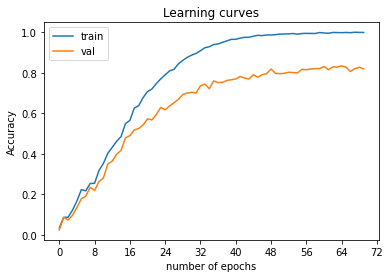

In [ ]:
from matplotlib.ticker import MaxNLocator
train_score=list(map(float,train_score))
eval_score=list(map(float,eval_score))
#print(eval_score)
ax = plt.figure().gca()
plt.plot(train_score)
plt.plot(eval_score)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.legend(['train', 'val'])
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Learning curves')
plt.show()

Test on data that hasn't been used

In [ ]:
print(evaluation(testloader))

0.7345132827758789


Display samples

In [ ]:
def img_display(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

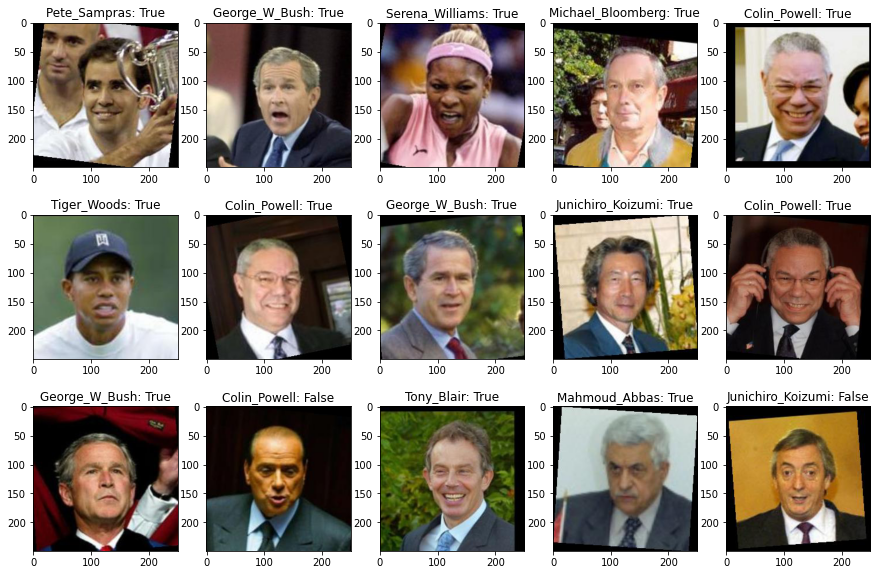

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
idx = list(LFW_dataset.class_to_idx.values())
classes = list(LFW_dataset.class_to_idx.keys())

names = {}
for key in idx: 
    for value in classes: 
        names[key] = value 
        classes.remove(value) 
        break

# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    monReseau.eval()
    for ax, image, label in zip(axis.flat,images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0).cuda()
        output_ = monReseau(image_tensor)
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title(str(names[output_.item()])+": " +str(k)) # add label